In [51]:
import logging
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from config import mongodb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [2]:
client = mongodb()
scrapperdb = client['scrapper']
collection = scrapperdb['news']

df = pd.DataFrame(list(collection.find()))
df.to_csv('../data/crypto_news_raw.csv')

In [3]:
df

,_id,source,slug,title,summary,text,author,topics,date
0,unlike-the-early-web-crypto-does-not-need-stat...,coindesk,unlike-the-early-web-crypto-does-not-need-stat...,"Unlike the Early Web, Crypto Does Not Need Sta...",Blockchain doesn't need ARPANET-type governmen...,Popular myth would have you believe the entrep...,Luke Stokes,"[Development, Opinion, Government Funding]",2021-02-06 12:00:00
1,binance-suspends-deposits-in-nigeria-following...,coindesk,binance-suspends-deposits-in-nigeria-following...,Binance Suspends Deposits in Nigeria Following...,Nigeria's central bank told financial institut...,Binance has temporarily suspended deposits in ...,Sandali Handagama,"[Africa, Regulation, Nigeria, Binance, Crypto ...",2021-02-05 22:08:01
2,if-whales-move-the-market-uniwhales-is-the-wha...,coindesk,if-whales-move-the-market-uniwhales-is-the-wha...,"If Whales Move the Market, UniWhales Is the Wh...",Want to see how DeFi’s biggest players are tra...,When Elon Musk changed his Twitter bio to “#bi...,Brady Dale,"[Uniswap, DeFi]",2021-02-05 21:55:16
3,market-wrap-bitcoin-rises-ethers-new-high-options,coindesk,market-wrap-bitcoin-rises-ethers-new-high-options,Market Wrap: Bitcoin Rises to $38.3K While Eth...,DeFi and the prospect of trading futures have ...,"Bitcoin made some gains Friday, but ether hit ...",Daniel Cawrey,"[Commodities, Bitcoin, Ether, Cardano, Cosmos,...",2021-02-05 21:39:10
4,square-crypto-consortium-craig-wright-bitcoin-...,coindesk,square-crypto-consortium-craig-wright-bitcoin-...,Square Crypto-Led Consortium Challenges Craig ...,The response asks general questions regarding ...,The Cryptocurrency Open Patent Alliance (COPA)...,Benjamin Powers,"[Square, Craig Wright, Jack Dorsey, Bitcoin Wh...",2021-02-05 21:12:35
...,...,...,...,...,...,...,...,...,...
52683,new-years-first-shock-bitcoin-crashes-300,newsbtc,new-years-first-shock-bitcoin-crashes-300,New Year’s First Shock: Bitcoin Crashes below ...,"After being titled as 2014’s worst investment,...","After being titled as \n\n, Bitcoin was expect...",Yashu Gola,"[bitcoin, bloomberg, btc usd, cryptocurrency, ...",2015-01-03 00:00:00
52684,printing-company-isg-now-accepts-bitcoin,newsbtc,printing-company-isg-now-accepts-bitcoin,Printing Company ISG Now Accepts Bitcoin,Canadian online 3D printing store ISG has anno...,Canadian online 3D printing store ISG has anno...,Guest Author,"[bitcoin, bitcoin acceptance, ISG, isg730, isg...",2020-10-07 00:00:00
52685,california-approves-bitcoin-transactions,newsbtc,california-approves-bitcoin-transactions,California Approves Bitcoin for Transactions,California has now become “Crypto-rnia”. The s...,California has now become “Crypto-rnia”.\n\nTh...,Guest Author,"[bitcoin, bitcoin transactions, california, CD...",2015-01-03 00:00:00
52686,green-man-gaming-says-forget-green-pay-bitcoin,newsbtc,green-man-gaming-says-forget-green-pay-bitcoin,Green Man Gaming Says Forget the Green; Pay wi...,"Like games? Like bitcoin? Well, here’s anoth...","Like games? Like bitcoin? Well, here’s anoth...",Guest Author,"[bitcoin, greenmangaming, News]",2020-10-07 00:00:00


In [5]:
analyzer = SentimentIntensityAnalyzer()

In [52]:
summary_scores = []
text_scores = []
for i in tqdm(range(len(df))):
    item = df.iloc[i]
    summary_score = analyzer.polarity_scores(item['summary'])['compound']
    text_score = analyzer.polarity_scores(item['text'])['compound']

    summary_scores.append(summary_score)
    text_scores.append(text_score)

# df.drop(columns=['summary_score', 'text_score'], inplace=True)
df.insert(0, "summary_score", summary_scores, True)
df.insert(0, "text_score", text_scores, True)

100%|██████████| 52688/52688 [09:26<00:00, 92.98it/s] 


In [71]:
df.sort_values(by=['date'], ascending=True, inplace=True)
from_date = df.iloc[0].date
to_date = df.iloc[-1].date
print(f'From {from_date} to {to_date}')

From 2015-01-01 08:48:14 to 2021-02-06 12:00:00


In [72]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    return np.concatenate((np.zeros(box_pts-1), np.convolve(y, box, mode='valid')))

In [78]:
plt.rcParams['figure.figsize'] = [16, 8]

grouped_df = df[['date', 'summary_score', 'text_score']]\
    .resample('d', on='date').mean().dropna(how='all')

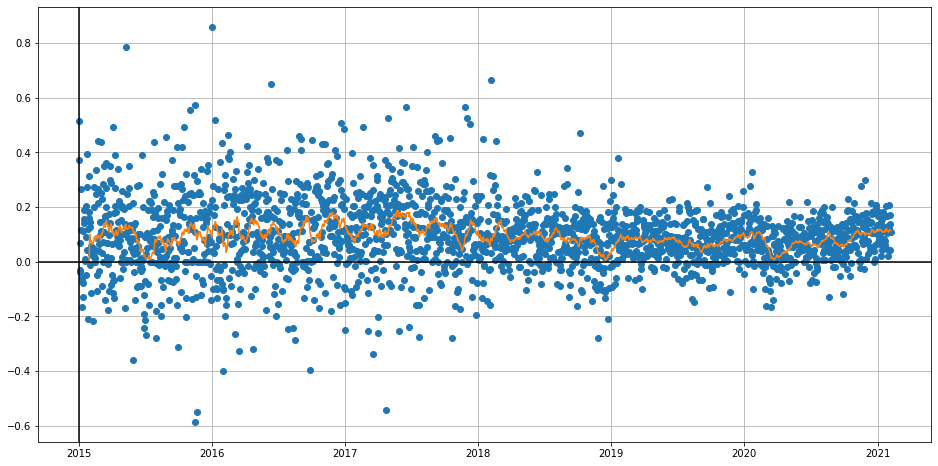

In [80]:
fig, ax = plt.subplots()
dates = grouped_df.index
ax.plot_date(dates, grouped_df['summary_score'])
ax.plot(dates, smooth(grouped_df['summary_score'], 30))
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=dates[0], color='k')

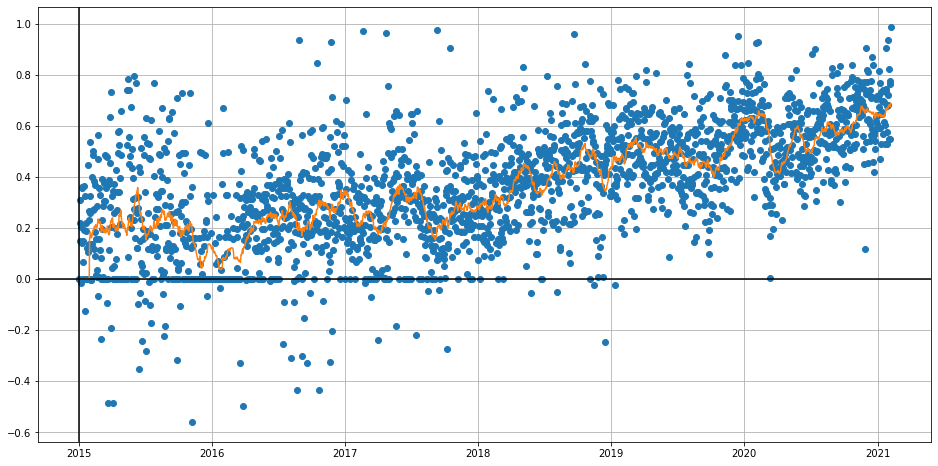

In [81]:
fig, ax = plt.subplots()
ax.plot_date(dates, grouped_df['text_score'])
ax.plot(dates, smooth(grouped_df['text_score'], 30))
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=dates[0], color='k')